## Import Packages

In [1]:
import os

import numpy as np
import pandas as pd
import polars as pl
import json

import warnings

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt

warnings.simplefilter(action = 'ignore', category = FutureWarning)
pl.Config.set_tbl_width_chars(150)
pl.Config.set_tbl_rows(1000)
pl.Config.set_tbl_cols(20)

seed = 7

## Import Datasets

In [2]:
df_players  = pl.read_parquet("data/final_datasets/player_performance.parquet")

with open('data/final_datasets/player_heatmap_features.json', 'r') as f:
    data = json.load(f)

df_spatial = pl.DataFrame({"id": [entry["playerId"] for entry in data],
                           "spatial_positioning": [entry["features"] for entry in data]
                          })

In [3]:
print(df_spatial.columns)
print(df_players.columns)

['id', 'spatial_positioning']
['Id', 'firstName', 'middleName', 'lastName', 'full_name', 'birthDay', 'age', 'weight', 'height', 'foot', 'club', 'currentTeamId', 'national_team', 'currentNationalTeamId', 'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'position', 'Role', 'status', 'market_value_in_eur', 'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name', 'UrlFBref', 'image_url', 'UrlTmarkt', 'TMarketID', 'WyScoutID', 'StatsBombID', 'FBrefID', 'Matches Played', 'Total Shots', 'Accurate Shots', 'Shot Accuracy', 'Goals', 'Shot Conversion', 'Penalties Taken', 'Penalties Scored', 'Penalty Conversion', 'Total Passes', 'Accurate Passes', 'Pass Accuracy', 'Key Passes', 'Assists', 'Run Attempts With Ball', 'Successful Runs With Ball', 'Perc Successful Runs With Ball', 'Crosses', 'Dribbles', 'Free Kick Shots', 'Free Kick Crosses', 'Aerial Duels', 'Aerial Duels Won', 'Perc Aerial Duels Won', 'Ground Defensive duels Won', 'Loose Ball Duels', 'Loose Balls Won', 'P

## Merge Datasets

In [50]:
df = df_players.join(df_spatial, left_on = "Id", right_on = "id", how = "left")

# Rename column to match desired output format
df = df.rename({"spatial_positioning": "spatial"})

columns = [
    'Id', 'age', 'weight', 'height',
    'position', 'Role', 'market_value_in_eur', 'highest_market_value_in_eur', 'contract_expiration_date', 'agent_name',
    'Matches Played', 'Total Shots', 'Accurate Shots', 'Shot Accuracy', 'Goals', 'Shot Conversion', 'Penalties Taken', 'Penalties Scored', 'Penalty Conversion', 'Free Kick Shots',
    'Total Passes', 'Accurate Passes', 'Pass Accuracy', 'Key Passes', 'Assists', 'Crosses', 'Free Kick Crosses', 
    'Run Attempts With Ball', 'Successful Runs With Ball', 'Perc Successful Runs With Ball', 'Dribbles',
    'Aerial Duels', 'Aerial Duels Won', 'Perc Aerial Duels Won', 'Ground Defensive duels Won', 'Loose Ball Duels', 'Loose Balls Won', 'Perc Loose Balls Won',
    'Sliding Tackles', 'Interceptions', 'Clearances', 'Blocks', 'Possession Regained', 'Own Goals',
    'GK Balls Attacked', 'GK Save Attempts', 'GK Successful Save Attempts', 'Perc GK Save Success',
    'spatial'
]

# Reorder columns (ignore missing ones)
df = df.select([col for col in columns if col in df.columns])

# Done
print(df.head())
print(df.columns)
print(df.dtypes)

shape: (5, 49)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┬───────┬───┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Id  ┆ age ┆ wei ┆ hei ┆ pos ┆ Rol ┆ mar ┆ hig ┆ contra ┆ agent ┆ … ┆ Inter ┆ Clear ┆ Block ┆ Posse ┆ Own   ┆ GK    ┆ GK    ┆ GK    ┆ Perc  ┆ spati │
│ --- ┆ --- ┆ ght ┆ ght ┆ iti ┆ e   ┆ ket ┆ hes ┆ ct_exp ┆ _name ┆   ┆ cepti ┆ ances ┆ s     ┆ ssion ┆ Goals ┆ Balls ┆ Save  ┆ Succe ┆ GK    ┆ al    │
│ i64 ┆ i32 ┆ --- ┆ --- ┆ on  ┆ --- ┆ _va ┆ t_m ┆ iratio ┆ ---   ┆   ┆ ons   ┆ ---   ┆ ---   ┆ Regai ┆ ---   ┆ Attac ┆ Attem ┆ ssful ┆ Save  ┆ ---   │
│     ┆     ┆ str ┆ str ┆ --- ┆ str ┆ lue ┆ ark ┆ n_date ┆ str   ┆   ┆ ---   ┆ i32   ┆ i32   ┆ ned   ┆ i32   ┆ ked   ┆ pts   ┆ Save  ┆ Succe ┆ list[ │
│     ┆     ┆     ┆     ┆ str ┆     ┆ _in ┆ et_ ┆ ---    ┆       ┆   ┆ i32   ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ ---   ┆ Attem ┆ ss    ┆ f64]  │
│     ┆     ┆     ┆     ┆     ┆     ┆ _eu ┆ val ┆ str    ┆       ┆   ┆       ┆ 

## Clean Datasets

In [51]:
role_encoder     = LabelEncoder()
position_encoder = LabelEncoder()

# Convert weight and height to float
df = df.with_columns([
    pl.col("weight").cast(pl.Float64),
    pl.col("height").cast(pl.Float64)
])

# Drop incomplete columns
df = df.drop(["market_value_in_eur", "highest_market_value_in_eur", "contract_expiration_date", "agent_name"])

df = df.with_columns([pl.Series("Role", role_encoder.fit_transform(df["Role"].to_list())),
                      pl.Series("position", position_encoder.fit_transform(df["position"].to_list()))
                    ])
df = df.filter(pl.col("spatial").is_not_null())

# number of rows with null in the spatial column
print(df.select([pl.col(c).is_null().sum().alias(f"{c}_nulls") for c in df.columns]))

## Numerical Encoding

In [56]:
exclude_cols  = ["Id", "spatial"]
cols_to_scale = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [pl.Int64, pl.Float64, pl.Int32]]

# Convert to pandas for sklearn scaling
df_pandas     = df.select(cols_to_scale).to_pandas()
scaler        = MinMaxScaler()
df_scaled     = scaler.fit_transform(df_pandas)
df_scaled     = pl.DataFrame(df_scaled, schema = cols_to_scale)

# Reconstruct the final DataFrame with the spatial column added back
df_scaled     = df_scaled.with_columns([df["Id"], df["spatial"]])

cols          = ["Id"] + [col for col in df_scaled.columns if col != "Id"]
df_scaled     = df_scaled.select(cols)

In [57]:
print(df_scaled.head())

shape: (5, 44)
┌─────┬─────┬─────┬─────┬─────┬─────┬─────┬─────┬────────┬───────┬───┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ Id  ┆ age ┆ wei ┆ hei ┆ pos ┆ Rol ┆ Tot ┆ Acc ┆ Shot   ┆ Goals ┆ … ┆ Inter ┆ Clear ┆ Block ┆ Posse ┆ Own   ┆ GK    ┆ GK    ┆ GK    ┆ Perc  ┆ spati │
│ --- ┆ --- ┆ ght ┆ ght ┆ iti ┆ e   ┆ al  ┆ ura ┆ Accura ┆ ---   ┆   ┆ cepti ┆ ances ┆ s     ┆ ssion ┆ Goals ┆ Balls ┆ Save  ┆ Succe ┆ GK    ┆ al    │
│ i64 ┆ f64 ┆ --- ┆ --- ┆ on  ┆ --- ┆ Sho ┆ te  ┆ cy     ┆ f64   ┆   ┆ ons   ┆ ---   ┆ ---   ┆ Regai ┆ ---   ┆ Attac ┆ Attem ┆ ssful ┆ Save  ┆ ---   │
│     ┆     ┆ f64 ┆ f64 ┆ --- ┆ f64 ┆ ts  ┆ Sho ┆ ---    ┆       ┆   ┆ ---   ┆ f64   ┆ f64   ┆ ned   ┆ f64   ┆ ked   ┆ pts   ┆ Save  ┆ Succe ┆ list[ │
│     ┆     ┆     ┆     ┆ f64 ┆     ┆ --- ┆ ts  ┆ f64    ┆       ┆   ┆ f64   ┆       ┆       ┆ ---   ┆       ┆ ---   ┆ ---   ┆ Attem ┆ ss    ┆ f64]  │
│     ┆     ┆     ┆     ┆     ┆     ┆ f64 ┆ --- ┆        ┆       ┆   ┆       ┆ 

In [58]:
# Extract spatial vectors as list of lists
spatial_series   = df_scaled.select("spatial").to_series()
spatial_features = np.array([vec for vec in spatial_series])  # shape: (n_players, n_dims)

# Scale spatial vectors if needed
weight_factor    = 3.0
spatial_features = spatial_features * weight_factor

# Convert other features
other_features   = df_scaled.drop(["Id", "spatial"]).to_numpy()

# Combine into final feature matrix
final_features   = np.hstack([other_features, spatial_features])

print("Other features shape:", other_features.shape)
print("Spatial features shape:", spatial_features.shape)
print("Final features shape:", final_features.shape)

Other features shape: (3020, 42)
Spatial features shape: (3020, 100)
Final features shape: (3020, 142)


## Clustering

#### KMeans

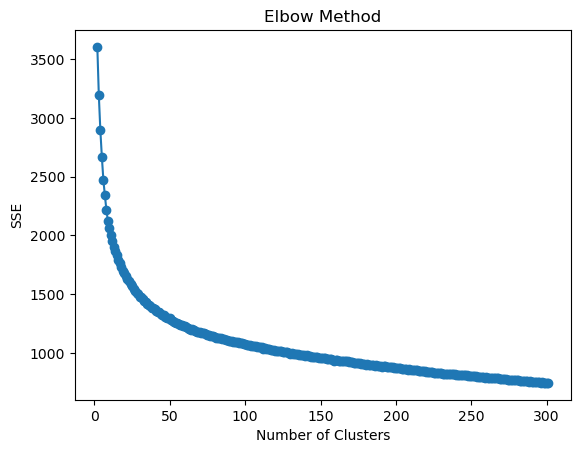

Silhouette Score: 0.1654357480716142
Davies-Bouldin Index: 1.739665664469551
Calinski-Harabasz Index: 362.7466021858113


In [60]:
sse = []
for k in range(2, 302):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(final_features)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 302), sse, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [84]:
# Final Clustering and Metrics
kmeans = KMeans(n_clusters = 3020, random_state = seed).fit(final_features)
labels = kmeans.labels_
print("Silhouette Score:", silhouette_score(final_features, labels))
print("Davies-Bouldin Index:", davies_bouldin_score(final_features, labels))
print("Calinski-Harabasz Index:", calinski_harabasz_score(final_features, labels))

/state/partition1/job-59412534/ipykernel_2095688/606952129.py:2: ConvergenceWarning: Number of distinct clusters (3008) found smaller than n_clusters (3020). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters = 3020, random_state = seed).fit(final_features)


Silhouette Score: 0.007947019242303888
Davies-Bouldin Index: 2.0829675650853197e-07
Calinski-Harabasz Index: 1.0


#### Gaussian Mixture Model

In [63]:
gmm        = GaussianMixture(n_components = 11, random_state = seed).fit(final_features)
gmm_labels = gmm.predict(final_features)
print(len(gmm_labels))

3020


#### DBSCAN

In [67]:
dbscan        = DBSCAN(eps = 0.5, min_samples = 10).fit(final_features)
dbscan_labels = dbscan.labels_
print(dbscan_labels)

[ 0  1  0 ... -1 -1 -1]


#### PCA

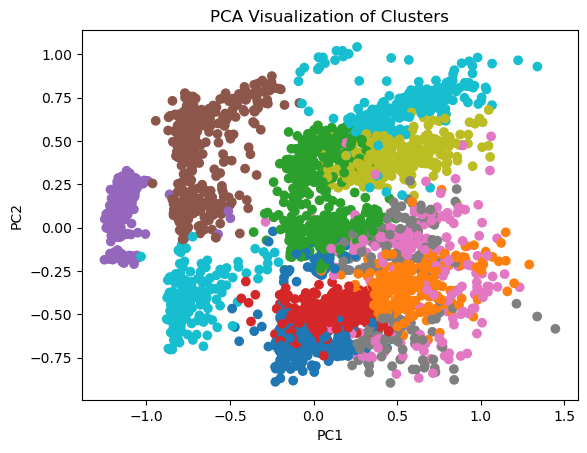

In [72]:
pca        = PCA(n_components = 3)
pca_result = pca.fit_transform(final_features)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c = labels, cmap = 'tab10')
plt.title("PCA Visualization of Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#### UMAP

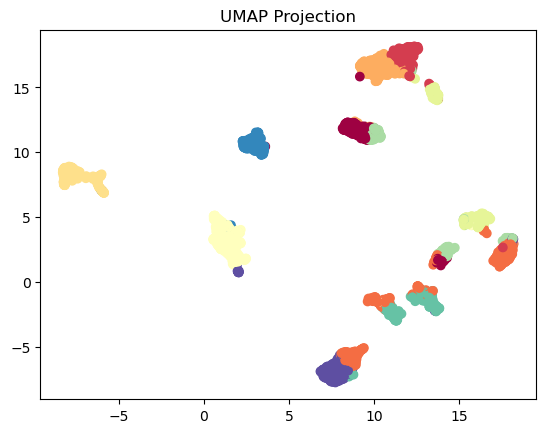

In [74]:
reducer   = umap.UMAP()
embedding = reducer.fit_transform(final_features)

plt.scatter(embedding[:, 0], embedding[:, 1], c = labels, cmap = 'Spectral')
plt.title("UMAP Projection")
plt.show()

#### t-SNE

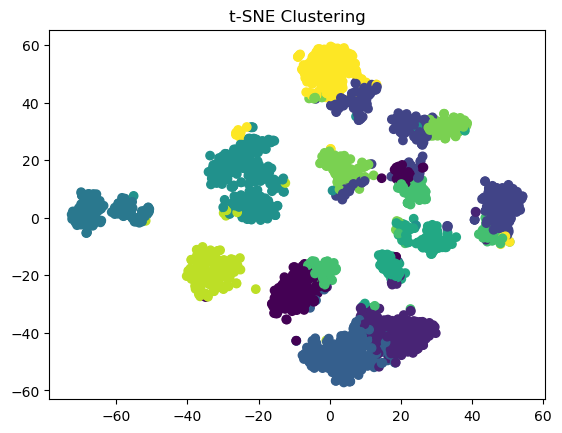

In [75]:
tsne        = TSNE(n_components = 2, random_state = seed)
tsne_result = tsne.fit_transform(final_features)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c = labels, cmap = 'viridis')
plt.title("t-SNE Clustering")
plt.show()

## Distance-Matching

#### Cosine, Euclidean, Manhattan

In [85]:
cos_sim   = cosine_similarity(final_features)
eucl_dist = euclidean_distances(final_features)
manh_dist = manhattan_distances(final_features)

# Top 10 most similar players to index 0
print(np.argsort(-cos_sim[0])[1:11])
print(np.argsort(-eucl_dist[0])[1:11])
print(np.argsort(-manh_dist[0])[1:11])

[1087 2054 1327 1496 2762 2608  121  746   67  428]
[ 481  965 2942 1497  702 2181  167 1545 2000  554]
[ 481 1853  702 1603  965  280  167  655 2667 1010]


#### k-Nearest Neighbors

In [78]:
knn                = NearestNeighbors(n_neighbors = 10, metric = "euclidean").fit(final_features)
distances, indices = knn.kneighbors(final_features)
print(indices)

## Mapping Back

In [93]:
# Add detail to df

def get_top_k_indices(distance_matrix, k = 10, ascending = True):
    # For cosine similarity use descending sort; for distances use ascending
    sorted_indices = np.argsort(distance_matrix, axis = 1)
    return sorted_indices[:, :k] if ascending else sorted_indices[:, -k:]

top10_cosine    = get_top_k_indices(cos_sim, k = 10, ascending = False) # Top 10 similar by cosine similarity (most similar = highest value)
top10_euclidean = get_top_k_indices(eucl_dist, k = 10, ascending = True) # Top 10 closest by Euclidean distance (lower = closer)
top10_manhattan = get_top_k_indices(manh_dist, k = 10, ascending = True) # Top 10 closest by Manhattan distance (lower = closer)

id_list         = df_scaled["Id"].to_list()
cosine_ids      = [[id_list[i] for i in row] for row in top10_cosine]
eucl_ids        = [[id_list[i] for i in row] for row in top10_euclidean]
manh_ids        = [[id_list[i] for i in row] for row in top10_manhattan]
neighbors       = [[id_list[i] for i in row] for row in indices]

df_scaled = df_scaled.with_columns([
    pl.Series("kmeans_label", labels),
    pl.Series("gmm_label", gmm_labels),
    pl.Series("dbscan_label", dbscan_labels),
    pl.Series("cosine_similar_ids", cosine_ids),
    pl.Series("euclidean_close_ids", eucl_ids),
    pl.Series("manhattan_close_ids", eucl_ids),
    pl.Series("nearest_neighbors", [list(row) for row in indices])
])


In [121]:
final_df = df_scaled.select([df_scaled.columns[0]] + df_scaled.columns[44:52]).sort("Id")
final_df.write_parquet("data/final_datasets/players_matched.parquet")
final_df

Id,kmeans_label,gmm_label,dbscan_label,cosine_similar_ids,euclidean_close_ids,manhattan_close_ids,nearest_neighbors
i64,i32,i64,i64,list[i64],list[i64],list[i64],list[i64]
12,2425,4,-1,"[331763, 18974, … 12]","[12, 239411, … 84536]","[12, 239411, … 84536]","[716, 2723, … 2308]"
33,1596,2,-1,"[25633, 14913, … 33]","[33, 20606, … 26971]","[33, 20606, … 26971]","[3, 2311, … 2001]"
36,40,0,0,"[19720, 301013, … 36]","[36, 14870, … 19720]","[36, 14870, … 19720]","[4, 2642, … 1334]"
38,1938,6,4,"[26024, 51127, … 38]","[38, 101647, … 209792]","[38, 101647, … 209792]","[2607, 1350, … 869]"
45,779,6,3,"[21095, 286382, … 45]","[45, 70136, … 21095]","[45, 70136, … 21095]","[2418, 419, … 2467]"
48,286,0,-1,"[15719, 20635, … 48]","[48, 70086, … 20612]","[48, 70086, … 20612]","[5, 405, … 2638]"
54,120,5,-1,"[26384, 7870, … 54]","[54, 8317, … 399676]","[54, 8317, … 399676]","[7, 684, … 559]"
56,1000,8,-1,"[23386, 91502, … 56]","[56, 284315, … 23386]","[56, 284315, … 23386]","[2669, 1614, … 1675]"
66,1982,4,-1,"[50461, 91, … 66]","[66, 230687, … 91]","[66, 230687, … 91]","[9, 78, … 12]"


## Testing

In [119]:
player_idx = 1654 # Marcelo Brozovic

# Get the full row as a tuple
row = (df_scaled.select([df_scaled.columns[0]] + df_scaled.columns[44:52])).sort("Id").row(player_idx)

# Print out each value by column index
print("Player ID:", row[0])
print("kmeans_label:", row[1])
print("gmm_label:", row[2])
print("dbscan_label:", row[3])
print("cosine_similar_ids:", row[4])
print("euclidean_close_ids:", row[5])
print("manhattan_close_ids:", row[6])
print("nearest_neighbors:", row[7])

Player ID: 69968
kmeans_label: 1541
gmm_label: 7
dbscan_label: -1
cosine_similar_ids: [210044, 25541, 21350, 70093, 3542, 277629, 14723, 3476, 3384, 69968]
euclidean_close_ids: [69968, 3384, 277629, 3476, 14723, 3542, 21350, 70093, 25541, 26065]
manhattan_close_ids: [69968, 3384, 277629, 3476, 14723, 3542, 21350, 70093, 25541, 26065]
nearest_neighbors: [1977, 192, 1085, 228, 922, 248, 1552, 408, 1809, 1916]
